Plots that need to be made:
1. search efficiency and cost as a function of itterations
    - put SFBO, MFBO, and random search on the same plot
2. MFBO PCA


For these plots I will need the feature data, selectivities, costs, and search results. 
In the search results, I will need the acquired COF ID and fidelity.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import pandas as pd
import torch
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 16})

## Load Data

In [2]:
###
#  Features and Molecular Simulation Data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))
# simulation data
y = [torch.from_numpy(np.transpose(file["henry_y"][:])), 
     torch.from_numpy(np.transpose(file["gcmc_y"][:]))]
# associated simulation costs
cost = [torch.from_numpy(np.transpose(file["henry_total_elapsed_time"][:])), 
        torch.from_numpy(np.transpose(file["gcmc_elapsed_time"][:]))]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  Bayesian Optimization Data
###
# dict_keys(['acquired_set', 'costs_acquired'])
mfbo_res = pickle.load(open('search_results/mfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_acquired', 'cost_acquired'])
sfbo_res = pickle.load(open('search_results/sfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_rs_max_mu', 'y_rs_max_sig_bot', 'y_rs_max_sig_top'])
random_search_res = pickle.load(open('search_results/random_search_results.pkl', 'rb'))

In [3]:
# check that BO runs are the same length
assert mfbo_res['acquired_set'].size()[0] == len(sfbo_res['ids_acquired'])

## Search Efficientcy Curves

In [4]:
nb_COFs_initialization = 3
iterations = range(1, len(sfbo_res['ids_acquired']) + 1)

def accumulated_cost(cost_acquired, nb_iterations):
    accumulated_cost = np.zeros(nb_iterations)
    for i in range(1, nb_iterations + 1):
        # accumulated cost
        accumulated_cost[i-1] = sum(cost_acquired[:i])
        
    return accumulated_cost

def get_y_max(ids_acquired, desred_fidelity, nb_iterations):
    y_max = np.zeros(nb_iterations)
    for i in range(1, nb_iterations + 1):
        # max value acquired up to this point
        y_max[i-1] = max(y[fid_acquired][ids_acquired[:i]])
    return y_max

TypeError: get_y_max() missing 3 required positional arguments: 'ids_acquired', 'fid_acquired', and 'nb_iterations'

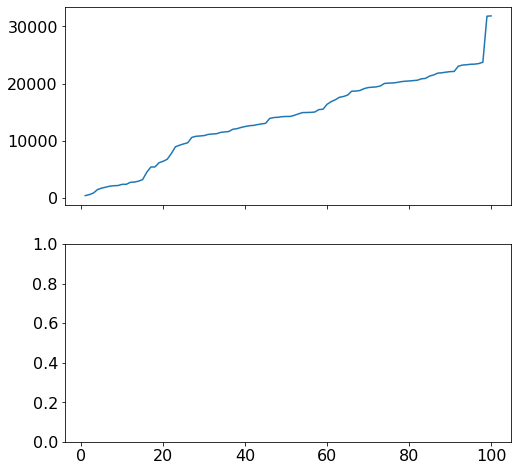

In [5]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for res in [sfbo_res, mfbo_res]:
    ###
    #  Cost
    #  - include random search with bounds
    ###
    acc_cost = accumulated_cost(res['cost_acquired'], len(iterations))
    ax[0].plot(iterations, acc_cost)
    ###
    #  Search Efficiency Curves
    ###
    # SFBO and MFBO
    if 'ids_acquired' in res.keys():
        ids_acquired = res['ids_acquired']
        desred_fidelity = 0
    else:
        ids_acquired = res['acquired_set'][0]
        desred_fidelity = 1
        
    y_max = get_y_max(ids_acquired, fid_acquired)
    ax[0].plot(iterations, y_max)

    
# Random Search (at low-fidelity)
ax[1].plot(iterations, random_search_res['y_rs_max_mu'], label="random search", color="tab:orange", lw=2)
ax[1].fill_between(iterations, random_search_res['y_rs_max_mu'] - random_search_res['y_rs_max_sig_bot'], 
                 random_search_res['y_rs_max_mu'] + random_search_res['y_rs_max_sig_top'], 
                 color="tab:orange", alpha=0.15)

ax[1].ylabel("max. $S^{(\ell)}_{Xe/Kr}$ acquired")
ax[1].ylim(ymin=0, ymax=20)
plt.xlabel("# evaluated COFs")
plt.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("./figs/cost_and_search_efficiency.pdf", format="pdf")
plt.show()

In [7]:



# ax1 = plt.subplot(2, 1, 1)
# plt.axvline(x=nb_COFs_initialization, 
#             label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
# plt.plot(iterations, accumulated_cost, label="cost", color="tab:blue")
# plt.legend(fontsize=12)
# plt.ylabel("accumulated cost [min]")
# plt.xlim(xmin=0, xmax=nb_iterations)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.ylim(ymin=0, ymax=35000)

# plt.subplot(2, 1, 2, sharex=ax1)
# plt.axhline(y=max(y), label="global maximm", color="tab:green", ls="--", lw=1.5)
# plt.axvline(x=nb_COFs_initialization, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
# plt.plot(iterations, y_max, label="BO", color="tab:red", zorder=3)

## Pirinciple Component Analysis

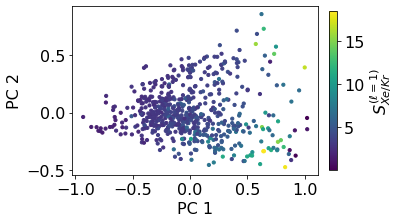

In [8]:
# color accordind to GCMC Selectivity 
# low-fidelity => X, black
# high-fidelity => +, red
# shuffle points before plotting to remove any bias


pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)



#low dimensional (PCA) visualization of the entire dataset
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig("./figs/PCA_feature_space_colored_by_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

### SFBO PCA

NameError: name 'ids_acquired' is not defined

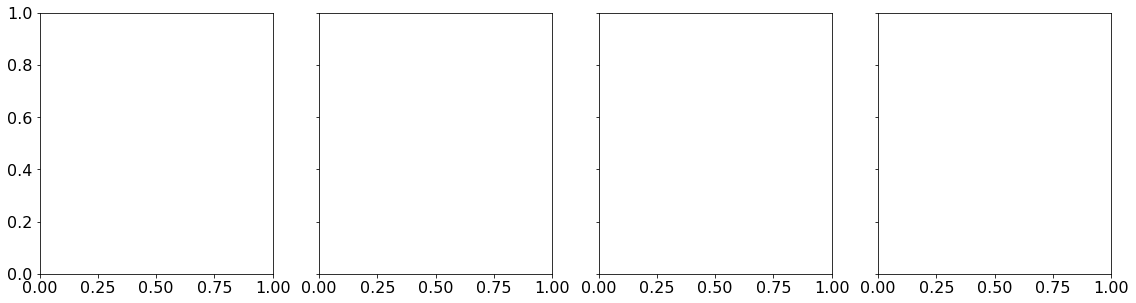

In [9]:
nb_acquired = [nb_COFs_initialization, 15, 30, 45]

max_y_seen = np.zeros(len(nb_acquired))
fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8])

    
for i in range(len(nb_acquired)):
    ids = ids_acquired[:nb_acquired[i]]
    max_y_seen[i] = y_max[i] 
    assert len(ids) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids, 0], X_2D[ids, 1], 
                  c=y[ids], marker="o", s=15, vmin=cb.vmin, vmax=cb.vmax)
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x')
ax[0].set_ylabel('PC 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.02, 'PC 1', ha='center')
plt.tight_layout()
# plt.savefig("./figs/SFBO_feature_space_acquired_COFs.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()

### MFBO PCA 

In [ ]:
nb_acquired = [2*nb_COFs_initialization, 15, 45, 60]
max_y_seen = np.zeros(len(nb_acquired))


fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8])

# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)
    
for i in range(len(nb_acquired)):
    ids  = ids_acquired[:nb_acquired[i]].detach().numpy()
    fids = fid_acquired[:nb_acquired[i]].detach().numpy()
    max_y_seen[i] = y_max[nb_acquired[i]]
    assert len(ids) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids, 0], X_2D[ids, 1], 
                  c=y[ids], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x')
ax[0].set_ylabel('PC 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.02, 'PC 1', ha='center')
plt.tight_layout()
# plt.savefig("feature_space_acquired_COFs.pdf", dpi=600, bbox_inches="tight", format="pdf")
plt.show()